In [1]:
# import necessary libraries
from PIL import Image

import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import os
import subprocess
import requests
import glob

In [2]:
np. random.seed(200)

In [4]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)
model.eval()

# Class labels from official PyTorch documentation for the pretrained model
# Note that there are some N/A's
# for complete list check https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
# we will use the same list for this notebook
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COLORS = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/research/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:52<00:00, 3.18MB/s] 


In [6]:
def get_prediction(img_path, threshold):
    img = Image.open(img_path)
    
    # Convert the image to a Pytorch tensor
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    
    # Perform inference
    pred = model([img])
    
    # Extract prediction and detach them from the computation graph
    pred_data = pred[0]
    
    # Convert tensors to NumPy array
    labels = pred_data['labels'].detach().cpu().numpy()
    boxes = pred_data['boxes'].detach().cpu().numpy()
    scores = pred_data['scores'].detach().cpu().numpy()
    
    # Filter predictions based on threshold
    valid_indices = scores > threshold
    
    # Keep only valid bounding boxes, and class labels
    pred_boxes = [((b[0], b[1]), (b[2], b[3])) for b in boxes[valid_indices]]
    pred_classes = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in labels[valid_indices]]

    return pred_boxes, pred_classes

def object_detection_api(img_path, threshold=0.5):
    boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rect_th = max(round(sum(img.shape) / 2 * 0.003), 2)
    text_th = max(rect_th - 1, 1)
    
    for i in range(len(boxes)):
        p1, p2 = (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1]))
        color = COLORS[COCO_INSTANCE_CATEGORY_NAMES.index(pred_cls[i])]
        cv2.rectangle(
            img, p1, p2, color=color, thickness=rect_th
        )
        
        w, h = cv2.getTextSize(pred_cls[i], 0, fontScale=rect_th/3, thickness=text_th)[0]
        
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(img, p1, p2, color=color, thickness=-1, lineType=cv2.LINE_AA)
        cv2.putText(img,
            pred_cls[i],  # Class name
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),  # Adjust text position
            cv2.FONT_HERSHEY_SIMPLEX,  # Font type
            rect_th / 3,  # Scale font size
            (255, 255, 255),  # White text color
            thickness=text_th + 1  # Text thickness
        )
    # Create a figure for displaying the image
    plt.figure(figsize=(15,12))
    # Display the image with bounding boxes and labels
    plt.imshow(img)
    # Remove x-axis ticks for a cleaner visualization
    plt.xticks([])
    # Remove y-axis ticks for a cleaner visualization
    plt.yticks([])
    # Show the final output image
    plt.show()
        
        

In [7]:
# Helper function to download file.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        subprocess.run(['wget', url, '-O', save_name, '-q'])

In [8]:
# Create directory to donwload inference data.
inference_dir = 'inference_data'
os.makedirs(inference_dir, exist_ok=True)

In [9]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/people.jpg',
    os.path.join(inference_dir, 'people.jpg')
)



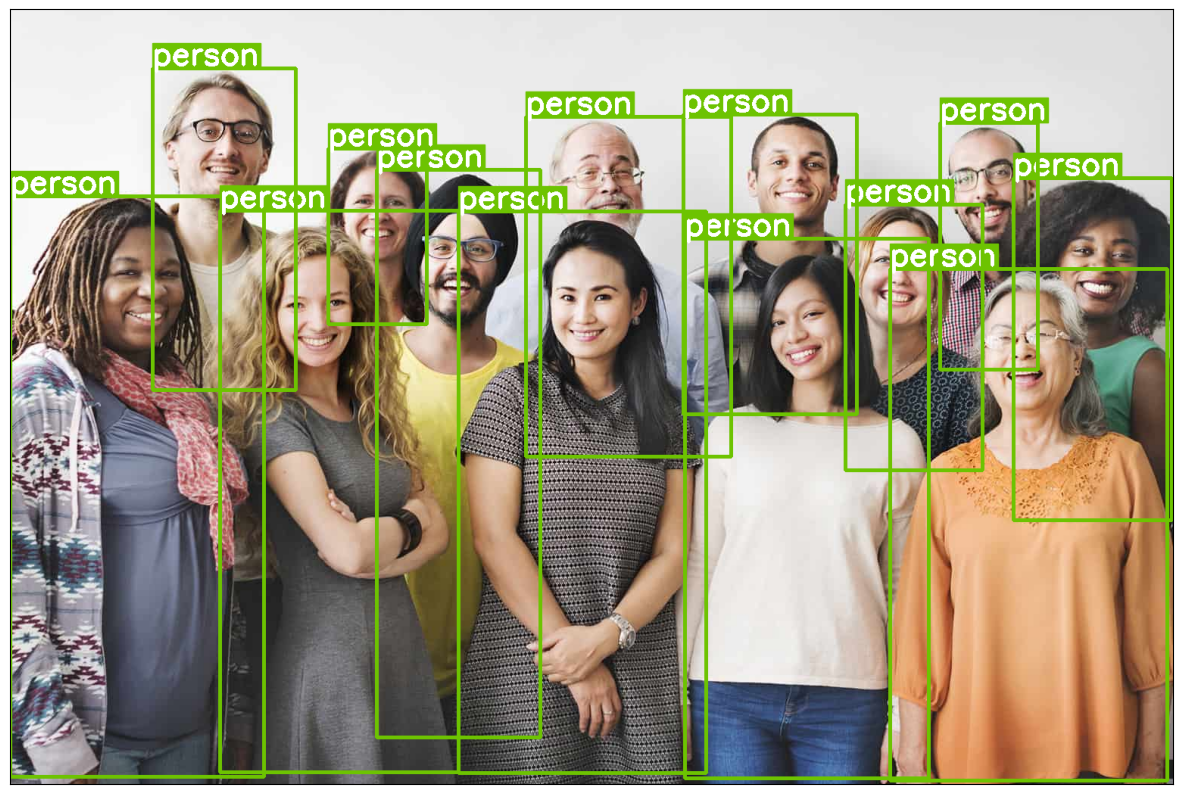

In [10]:
# Use the api pipeline for object detection.
# The threshold is set manually, the model sometimes predicts
# andom structures as a potential object, so we set a threshold to keep objects
# with better prediction scores.
object_detection_api(os.path.join(inference_dir, 'people.jpg'), threshold=0.8)

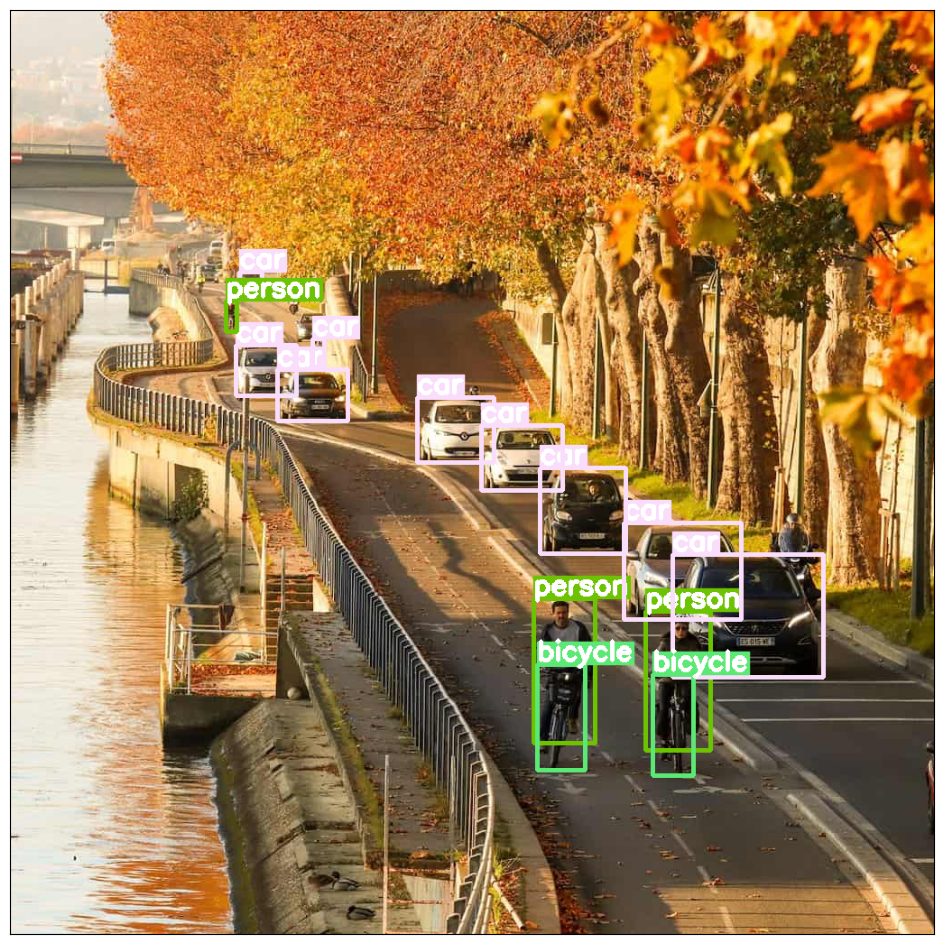

In [11]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/vehicles.jpg',
    os.path.join(inference_dir, 'vehicles.jpg')
)

object_detection_api(os.path.join(inference_dir, 'vehicles.jpg'), threshold=0.8)

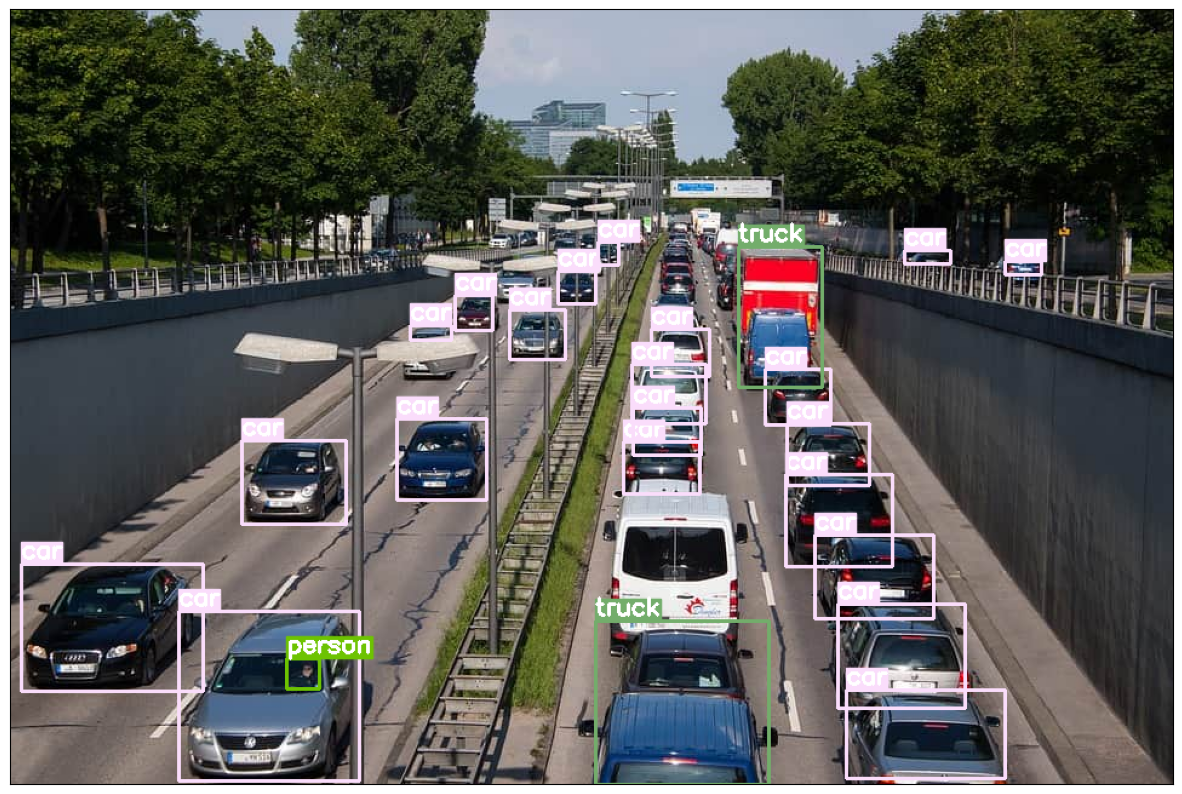

In [12]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/traffic_scene.jpg',
    os.path.join(inference_dir, 'traffic_scene.jpg')
)

object_detection_api(os.path.join(inference_dir, 'traffic_scene.jpg'), threshold=0.8)

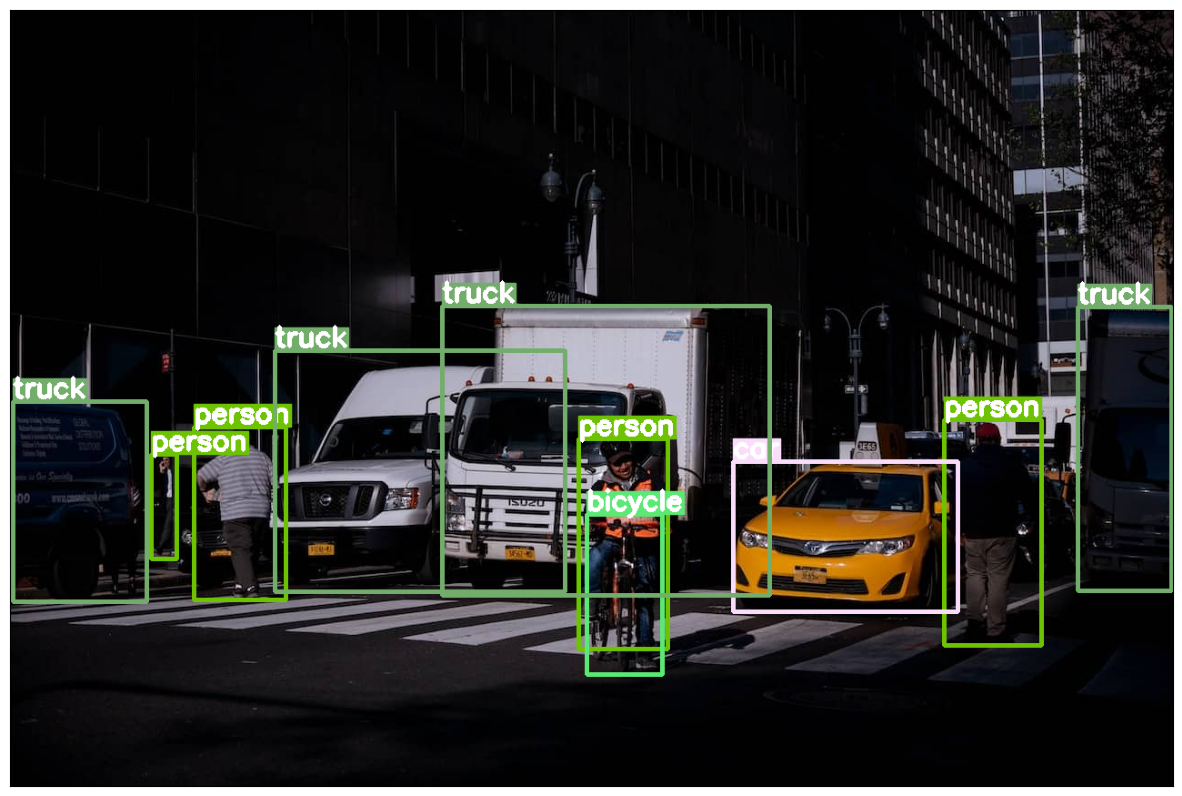

In [13]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/night-time.jpg',
    os.path.join(inference_dir, 'night-time.jpg')
)

object_detection_api(os.path.join(inference_dir, 'night-time.jpg'), threshold=0.8)

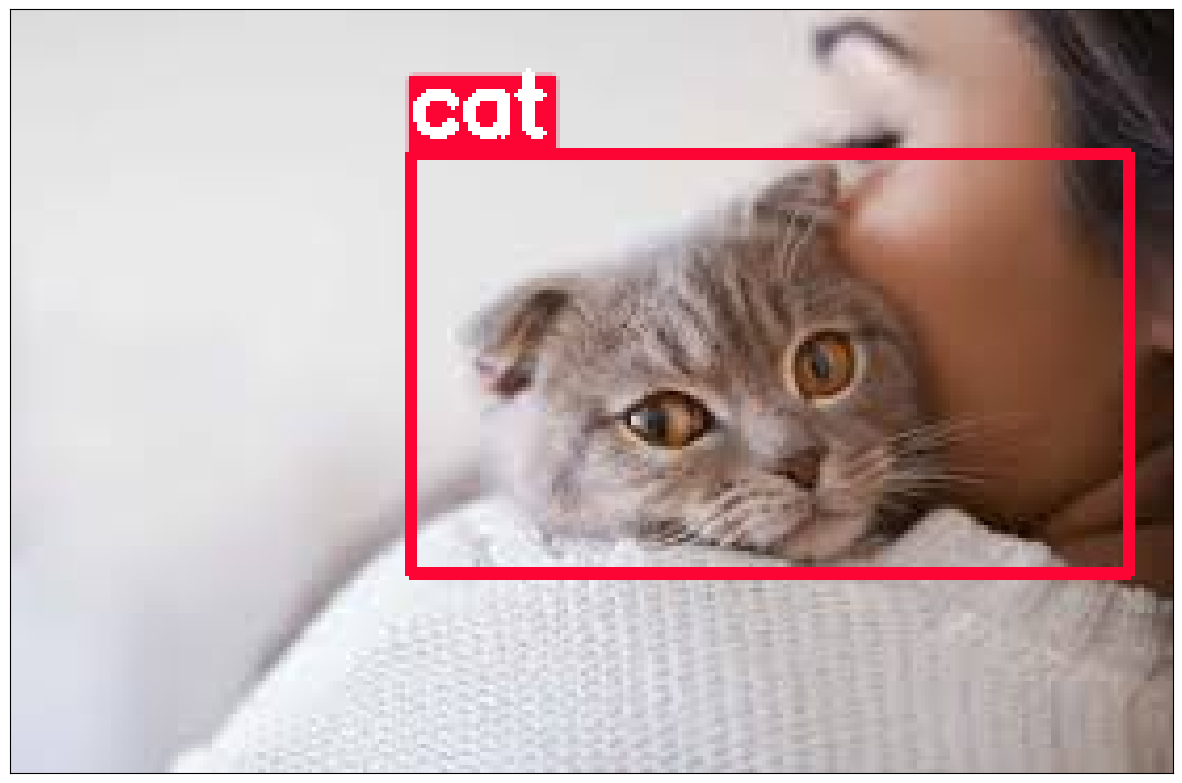

In [17]:
object_detection_api(os.path.join(inference_dir, 'cats.webp'), threshold=0.9)

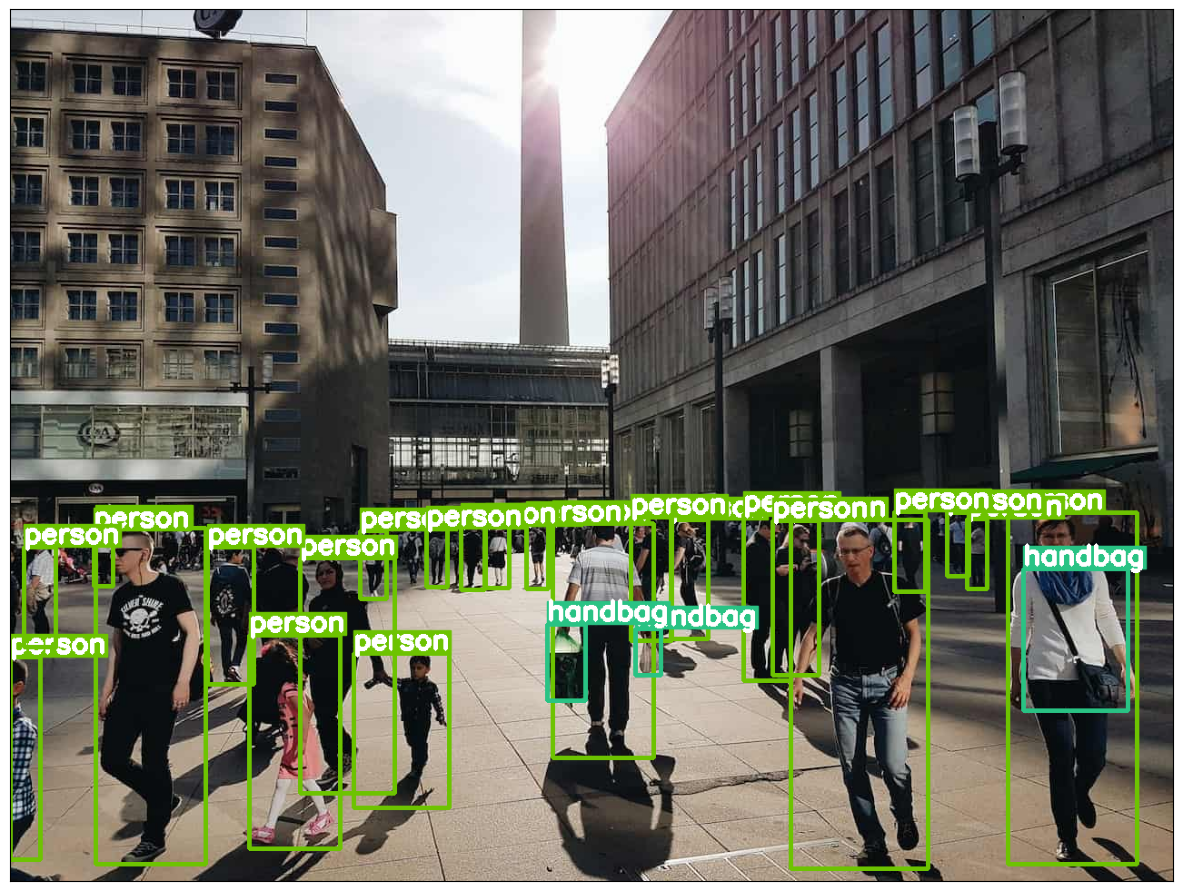

In [18]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/crowd.jpg',
    os.path.join(inference_dir, 'crowd.jpg')
)

object_detection_api(os.path.join(inference_dir, 'crowd.jpg'), threshold=0.8)

In [22]:
import time  # Import time module to measure inference speed

# Load the pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)
# Set model to evaluation mode
model.eval()


def check_inference_time(image_path, gpu=False):
    """
    Measures the inference time of the Faster R-CNN model on a given image.

    Parameters:
        image_path (str): Path to the input image.
        gpu (bool): Whether to run inference on GPU (default: False).

    Returns:
        float: Time taken (in seconds) for model inference.
    """

    # Open the image using PIL (Pillow)
    img = Image.open(image_path)

    # Convert image to a PyTorch tensor using torchvision transforms
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    # Move model and image to GPU or CPU based on the 'gpu' flag
    if gpu:
        if torch.backends.mps.is_available():
            model.to("mps")
            img = img.to("mps")
        else:
            model.cuda()  # Move model to GPU
            img = img.cuda()  # Move image to GPU
    
    else:
        model.cpu()  # Move model to CPU
        img = img.cpu()  # Move image to CPU (not strictly needed, but for consistency)

    # Start measuring inference time
    start_time = time.time()

    # Perform inference (forward pass)
    pred = model([img])

    # End time after inference is completed
    end_time = time.time()

    # Return the total time taken for inference
    return end_time - start_time


In [26]:
# Let's run inference on all the downloaded images and average their inference time
img_paths = [
    path for path in glob.glob(os.path.join(inference_dir, '*')) \
    if path.split('.')[-1].lower() in ["jpeg", "jpg", "png"]
]
print(img_paths)
# gpu_time = sum(
#     [check_inference_time(img_path, gpu=True) \
#      for img_path in img_paths])/len(img_paths
# )
cpu_time = sum(
    [check_inference_time(img_path, gpu=False) \
     for img_path in img_paths])/len(img_paths
)

gpu_time = 0


print('\n\nAverage Time take by the model with GPU = {}s\nAverage Time take by the model with CPU = {}s'.format(gpu_time, cpu_time))

['inference_data/horse.jpg', 'inference_data/night-time.jpg', 'inference_data/crowd.jpg', 'inference_data/vehicles.jpg', 'inference_data/bird.jpg', 'inference_data/person.jpg', 'inference_data/traffic_scene.jpg', 'inference_data/people.jpg']


Average Time take by the model with GPU = 0s
Average Time take by the model with CPU = 1.053526759147644s
